In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as tkr
from datetime import datetime as dt 
from datetime import timedelta
import seaborn as sns
import missingno as ms
import math
import calendar
import warnings
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.arima_model import ARIMA
import matplotlib.ticker as ticker
from fbprophet import Prophet
warnings.filterwarnings('ignore')
%matplotlib inline

In [3]:
%load_ext autoreload
%autoreload 
%aimport MyFunctions
myfunc = MyFunctions

In [4]:
# read the data from the csv files
stations = pd.read_csv("example_sprit_cut_station.csv", delimiter=";")
prices = pd.read_csv("example_sprit_cut_prices.csv", delimiter=";")

### Task 0

In [10]:
# get the IDs based on time history
number_of_days = prices.groupby('STID')['DATE_CHANGED'].nunique().sort_values().index.values
#print(number_of_days)

In [248]:
# get the longest activity history and choose 100 stations from it
longest_history = number_of_days
longest_history = longest_history[-100:]
#print(longest_history)

In [249]:
def open_7_till_20(time_stamp):
    time_stamp = time_stamp.split(".")[0]
    time = dt.strptime(time_stamp, "%Y-%m-%d %H:%M:%S")
    is_from_7_to_20 = time.hour > 6 and time.hour < 21
    return is_from_7_to_20    

In [250]:
# choose only values that are between 7 and 20 o'clock in the longest history
prices_between_7_20 = prices.loc[prices["STID"].isin(longest_history)]
prices_between_7_20 = prices_between_7_20.loc[prices_between_7_20["DATE_CHANGED"].apply(open_7_till_20)]

In [251]:
#print(prices_between_7_20)

In [252]:
# convert time stamp to days
prices_between_7_20["DATE_CHANGED"] = prices_between_7_20["DATE_CHANGED"].apply(myfunc.time_stamp_to_day) 
#print(prices_between_7_20)

In [253]:
# get time sorted ID groups
id_time_grouped = prices_between_7_20.groupby("STID")
# find earliest and latest date that was measured
earliest_day = None
latest_day   = None
for key, item in id_time_grouped:
    id_time_group  = id_time_grouped.get_group(key)
    group_date_min = id_time_group.head(1)["DATE_CHANGED"].values[0]
    group_date_max = id_time_group.tail(1)["DATE_CHANGED"].values[0]
    if earliest_day == None  or group_date_min < earliest_day:
        earliest_day = group_date_min
    if latest_day == None or group_date_max > latest_day:
        latest_day = group_date_max

earliest_date = dt.strptime(earliest_day, "%Y-%m-%d") 
latest_date = dt.strptime(latest_day, "%Y-%m-%d") 
#print("earliest_date: " + str(earliest_date))
#print("max date: " + str(latest_date))

In [254]:
# get the date of the first observed value of all stations 
min_date = prices.groupby('STID')['DATE_CHANGED'].min()
min_date_string = min_date.sort_values().head(1).values[0]
# get the first full day after first day measured
min_date = (myfunc.time_stamp_to_date(min_date_string) + timedelta(days = 1)).replace(hour = 7, minute = 0, second = 0)


In [255]:
# count days to construct list of dates between earliest and latest date
passed_days = (latest_date - earliest_date).days 
date_list = [str((min_date + timedelta(days=1*x)).date()) for x in range(0, passed_days)]
#print(date_list)

In [256]:
# create dataframes for average prices were columns are dates and rows are different stations
price_e5 = pd.DataFrame(columns = date_list)
price_e10 = pd.DataFrame(columns = date_list)
price_diesel = pd.DataFrame(columns = date_list)
#print(price_e5.head())

price_e5.insert(loc=0, column="TIME_ID", value = id_time_grouped.groups.keys())
price_e10.insert(loc=0, column="TIME_ID", value = id_time_grouped.groups.keys())
price_diesel.insert(loc=0, column="TIME_ID", value = id_time_grouped.groups.keys())
#print(price_e5.head())

In [257]:
# fill dataframes with price values
for key, item in id_time_grouped:
    id_time_group  = id_time_grouped.get_group(key)
    ids_in_date_list = id_time_group["DATE_CHANGED"].isin(date_list)
    #print(ids_in_date_list)
    corrected_date_list_id = id_time_group.loc[ids_in_date_list]
    #print(corrected_date_list_id)
    
    # get daily mean prices
    mean_price = corrected_date_list_id.groupby("DATE_CHANGED")[["E5", "E10", "DIESEL"]].mean()
    #print(mean_price)
    
    # get dates of mean prices
    mean_price_indexes = mean_price.index
    # get boolean index of those dates that were measured for the current id
    column_indexes_of_e5 = price_e5.loc[price_e5["TIME_ID"] == key].columns.isin(mean_price_indexes)
    # set e5 prices of current id for the days measured
    price_e5.loc[price_e5["TIME_ID"] == key, column_indexes_of_e5] = mean_price["E5"].values
    
    # get boolean index of those dates that were measured for the current id
    column_indexes_of_e10 = price_e10.loc[price_e10["TIME_ID"] == key].columns.isin(mean_price_indexes)
    # set e10 prices of current id for the days measured
    price_e10.loc[price_e10["TIME_ID"] == key, column_indexes_of_e10] = mean_price["E10"].values
    
     # get boolean index of those dates that were measured for the current id
    column_indexes_of_diesel = price_diesel.loc[price_diesel["TIME_ID"] == key].columns.isin(mean_price_indexes)
    # set diesel prices of current id for the days measured
    price_diesel.loc[price_diesel["TIME_ID"] == key, column_indexes_of_diesel] = mean_price["DIESEL"].values
    
    
    


In [258]:
# fill missing values with value of next row
price_e5 = price_e5.fillna(method = "bfill")
price_e10 = price_e10.fillna(method = "bfill")
price_diesel = price_diesel.fillna(method = "bfill")
#ms.matrix(price_diesel)


### Task 1

In [259]:
# apply the trivial model -> moving average
# 3 stations only
stations_3_price_e5 = price_e5.drop("TIME_ID", axis = 1).head(3)/1000
stations_3_price_e10 = price_e10.drop("TIME_ID", axis = 1).head(3)/1000
stations_3_price_diesel = price_diesel.drop("TIME_ID", axis = 1).head(3)/1000
#number of training samples taken into account for prediction
train_size = 40
# number of days to predict
test_size = 1

number_splits = 5
tscv = TimeSeriesSplit(max_train_size=train_size, n_splits=number_splits)

# lists for mean absolute deviation
mad_price_e5 = []
mad_price_e10 = []
mad_price_diesel = []

# lists of mean absolute percentage error
mape_price_e5 = []
mape_price_e10 = []
mape_price_diesel = []


In [260]:
def apply_moving_average(train_data, test_data):
    # Set parameters of ARIMA model:
    # 0: Order Autoregressive model
    # 0: degree of differencing
    # 4: order of moving average model
    # -> MA model only
    mw_model = ARIMA(train_data.values, order=(0, 0, 4))
    mw_model_fit = mw_model.fit(start_params=(0, 0, 0, 0, 0))
    pred = mw_model_fit.predict(start=len(train_data), end=(len(train_data) + len(test_data) - 1))
    return pred

def get_mad(gt, pred):
    gt_mean = gt.mean()
    mad = np.sum(np.abs((pred - gt_mean)))/pred.shape[0]
    return mad

def get_mape(gt, pred):
    mape = 100*np.sum(np.abs((gt - pred)/gt))/pred.shape[0]
    return mape


def generate_plt_ticks(nr_ticks, list):
    all_indexes = len(list)-1
    dist = all_indexes/(nr_ticks-1)
    index_list = []
    for nr in range(nr_ticks):
        index_list.append(int(nr*dist))
    tick_list = []
    for index in index_list:
        tick_list.append(list[index])
    return index_list, tick_list



def plot_time_series_pred(train_data, test_data, pred_data, title):
    date_list = list(train_data.index) + list(test_data.index)
    train_range = list(range(len(train_data)))
    test_range = list(range(len(train_data), len(train_data) + len(test_data)))

    plt.plot(train_range, train_data.values, 'black', label="Training data")
    plt.plot(test_range, test_data.values, 'bo', label="True")
    plt.plot([train_range[-1], test_range[0]], [train_data.values[-1], test_data.values], 'b-')
    plt.plot(test_range, pred_data, 'ro', label="Predicted")
    plt.plot([train_range[-1], test_range[0]], [train_data.values[-1], pred_data], 'r-')
    x_index_list_ticks, x_label_list_ticks = generate_plt_ticks(10, date_list)
    plt.xticks(fontsize=8, rotation=30)
    plt.xticks(x_index_list_ticks, x_label_list_ticks)
    plt.gca().yaxis.set_major_formatter(ticker.FormatStrFormatter('%1.2f €'))
    plt.legend()
    plt.title(title)
    plt.show()

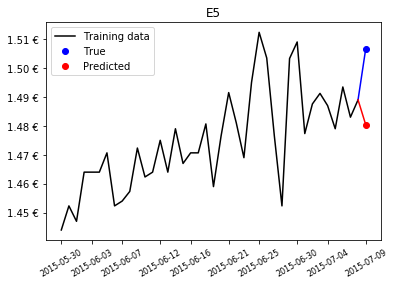

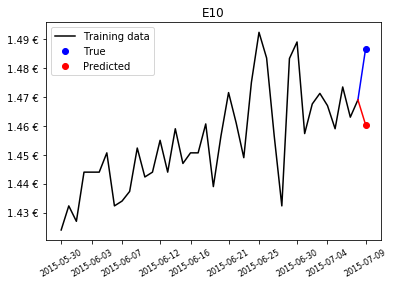

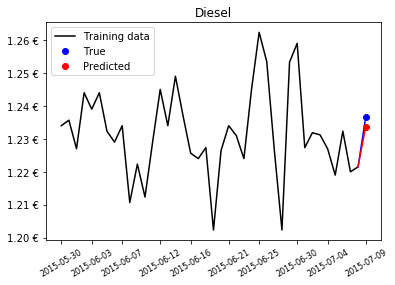

In [261]:

for train_index, test_index in tscv.split(stations_3_price_e5.loc[0]):
    #print(stations_3_price_e5.loc[0])
    # loop through three stations
    for index, station_e5 in stations_3_price_e5.iterrows():
        # get train and test data
        e5_train = station_e5[train_index]
        e5_test = station_e5[test_index][:test_size]
        e5_pred = apply_moving_average(e5_train, e5_test)
        
        mad_price_e5.append(get_mad(e5_test.values, e5_pred))
        mape_price_e5.append(get_mape(e5_test.values, e5_pred))

    
    # loop through three stations    
    for index, station_e10 in stations_3_price_e10.iterrows():
        # get train and test data
        e10_train = station_e10[train_index]
        e10_test = station_e10[test_index][:test_size]
        e10_pred = apply_moving_average(e10_train, e10_test)
        
        mad_price_e10.append(get_mad(e10_test.values, e10_pred))
        mape_price_e10.append(get_mape(e10_test.values, e10_pred))
  
    # loop through three stations
    for index, station_diesel in stations_3_price_diesel.iterrows():
        # get train and test data
        diesel_train = station_diesel[train_index]
        diesel_test = station_diesel[test_index][:test_size]
        diesel_pred = apply_moving_average(diesel_train, diesel_test)
        
        mad_price_diesel.append(get_mad(diesel_test.values, diesel_pred))
        mape_price_diesel.append(get_mape(diesel_test.values, diesel_pred))

# llot Example Predictions 
plot_time_series_pred(e5_train, e5_test, e5_pred, "E5")
plot_time_series_pred(e10_train, e10_test, e10_pred, "E10")
plot_time_series_pred(diesel_train, diesel_test, diesel_pred, "Diesel")


In [262]:
# get average mean absolute deviation
average_mad_e5_ma = sum(mad_price_e5)/len(mad_price_e5)
average_mad_e10_ma = sum(mad_price_e10)/len(mad_price_e10)
average_mad_diesel_ma = sum(mad_price_diesel)/len(mad_price_diesel)

# get average mean absolute percentage error
average_mape_e5_ma = sum(mape_price_e5)/len(mape_price_e5)
average_mape_e10_ma = sum(mape_price_e10)/len(mape_price_e10)
average_mape_diesel_ma = sum(mape_price_diesel)/len(mape_price_diesel)

print("E5 average mad error: %1.4f €"  % average_mad_e5_ma)
print("E10 average mad error: %1.4f €" % average_mad_e10_ma)
print("Diesel average mad error: %1.4f €" % average_mad_diesel_ma)
print("E5 average mape error: %3.2f %%"  % average_mape_e5_ma)
print("E10 average mape error: %3.2f %%" % average_mape_e10_ma)
print("Diesel average mape error: %3.2f %%" % average_mape_diesel_ma)

E5 average mad error: 0.0123 €
E10 average mad error: 0.0124 €
Diesel average mad error: 0.0133 €
E5 average mape error: 0.85 %
E10 average mape error: 0.87 %
Diesel average mape error: 1.09 %


In [263]:
e5 = pd.DataFrame(stations_3_price_e5).reset_index()
e10 = pd.DataFrame(stations_3_price_e10).reset_index()
diesel = pd.DataFrame(stations_3_price_diesel).reset_index()

# number of training samples taken into account for prediction
train_size = 20
# number of samples to predict
test_size = 1

tscv = TimeSeriesSplit(max_train_size=train_size, n_splits=5)

mad_prices_e5_prophet = []
mad_prices_e10_prophet = []
mad_prices_diesel_prophet = []

mape_prices_e5_prophet = []
mape_prices_e10_prophet = []
mape_prices_diesel_prophet = []

In [264]:
def plot_time_series_pred_prophet(train_data, test_data, pred_data, title):
    date_list = list(train_data["ds"]) + list(test_data["ds"])
    train_range = list(range(len(train_data)))
    test_range = list(range(len(train_data), len(train_data) + len(test_data)))
   # print(train_data)
    plt.plot(train_range, train_data["y"].values, 'black', label="Training data")
    plt.plot(test_range, test_data["y"].values, 'bo', label="True")
    plt.plot([train_range[-1], test_range[0]], [train_data["y"].values[-1], test_data["y"].values], 'b-')
    plt.plot(test_range, pred_data.tail(len(test_data))["yhat"], 'ro', label="Predicted")
    plt.plot([train_range[-1], test_range[0]], [train_data["y"].values[-1], pred_data.tail(len(test_data))["yhat"]], 'r-')
    x_index_list_ticks, x_label_list_ticks = generate_plt_ticks(10, date_list)
    plt.xticks(fontsize=8, rotation=30)
    plt.xticks(x_index_list_ticks, x_label_list_ticks)
    plt.gca().yaxis.set_major_formatter(ticker.FormatStrFormatter('%1.2f €'))
    plt.legend()
    plt.title(title)
    plt.show()

In [265]:
def apply_fb_prophet(train_data, max_test_data_size):
    m = Prophet()
    m.fit(train_data)
    future_df = m.make_future_dataframe(periods=max_test_data_size)
    pred = m.predict(future_df)
    return pred

In [266]:
for train_index, test_index in tscv.split(e5.loc[0]):  
   
    for index, station_e5 in e5.iterrows():
        df_station_e5 = pd.DataFrame(np.array([station_e5.index.values, station_e5.values]).T, columns=['ds', 'y'])
        e5_train = df_station_e5.iloc[train_index]
        e5_test = df_station_e5.iloc[test_index].head(test_size)  
        e5_pred = apply_fb_prophet(e5_train, test_size)
        
        mad_prices_e5_prophet.append(get_mad(e5_test["y"].values, e5_pred.tail(test_size)["yhat"].values))
        mape_prices_e5_prophet.append(get_mape(e5_test["y"].values, e5_pred.tail(test_size)["yhat"].values))

    for index, station_e10 in e10.iterrows():
        df_station_e10 = pd.DataFrame(np.array([station_e10.index.values, station_e10.values]).T, columns=['ds', 'y'])
        e10_train = df_station_e10.iloc[train_index]
        e10_test = df_station_e10.iloc[test_index].head(test_size)
        e10_pred = apply_fb_prophet(e10_train, test_size)
  
        mad_prices_e10_prophet.append(get_mad(e10_test["y"].values, e10_pred.tail(test_size)["yhat"].values))
        mape_prices_e10_prophet.append(get_mape(e10_test["y"].values, e10_pred.tail(test_size)["yhat"].values))
  
    for index, station_diesel in diesel.iterrows():
        df_station_diesel = pd.DataFrame(np.array([station_diesel.index.values, station_diesel.values]).T, columns=['ds', 'y'])
        diesel_train = df_station_diesel.iloc[train_index]
        diesel_test = df_station_diesel.iloc[test_index].head(test_size)
        diesel_pred = apply_fb_prophet(diesel_train, test_size)
        
        mad_prices_diesel_prophet.append(get_mad(diesel_test["y"].values, diesel_pred.tail(test_size)["yhat"].values))
        mape_prices_diesel_prophet.append(get_mape(diesel_test["y"].values, diesel_pred.tail(test_size)["yhat"].values))
        


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 15.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 15.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 15.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run pr

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 15.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 15.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 15.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of

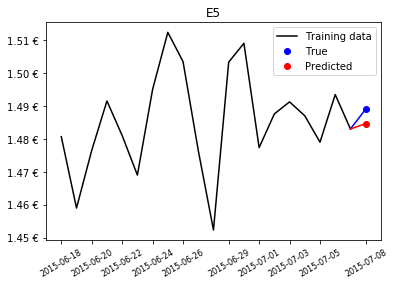

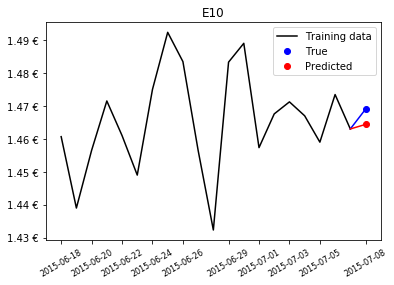

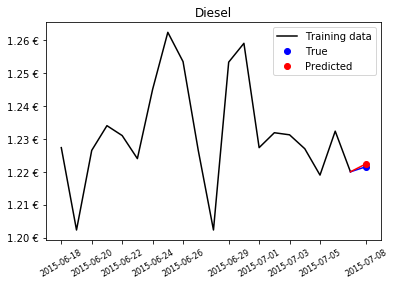

In [267]:
plot_time_series_pred_prophet(e5_train, e5_test, e5_pred, "E5")
plot_time_series_pred_prophet(e10_train, e10_test, e10_pred, "E10")
plot_time_series_pred_prophet(diesel_train, diesel_test, diesel_pred, "Diesel")

In [268]:
# get average mean absolute deviation
average_mad_e5_prophet = sum(mad_prices_e5_prophet)/len(mad_prices_e5_prophet)
average_mad_e10_prophet = sum(mad_prices_e10_prophet)/len(mad_prices_e10_prophet)
average_mad_diesel_prophet = sum(mad_prices_diesel_prophet)/len(mad_prices_diesel_prophet)

# get average mean absolute percentage error
average_mape_e5_prophet = sum(mape_prices_e5_prophet)/len(mape_prices_e5_prophet)
average_mape_e10_prophet = sum(mape_prices_e10_prophet)/len(mape_prices_e10_prophet)
average_mape_diesel_prophet = sum(mape_prices_diesel_prophet)/len(mape_prices_diesel_prophet)

print("E5 average mad error: %1.4f €"  % average_mad_e5_prophet)
print("E10 average mad error: %1.4f €" % average_mad_e10_prophet)
print("Diesel average mad error: %1.4f €" % average_mad_diesel_prophet)
print("E5 average mape error: %3.2f %%"  % average_mape_e5_prophet)
print("E10 average mape error: %3.2f %%" % average_mape_e10_prophet)
print("Diesel average mape error: %3.2f %%" % average_mape_diesel_prophet)

E5 average mad error: 0.0144 €
E10 average mad error: 0.0136 €
Diesel average mad error: 0.0146 €
E5 average mape error: 1.00 %
E10 average mape error: 0.96 %
Diesel average mape error: 1.18 %


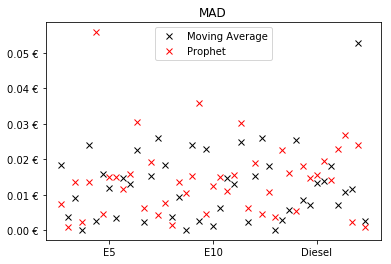

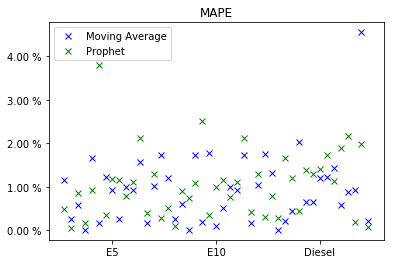

In [269]:
# vizualization of results of prophet and moving average model
num_points = len(mape_prices_e5_prophet + mape_prices_e10_prophet + mape_prices_diesel_prophet)

# plot all mean absolute deviation points
plt.plot(mad_price_e5 + mad_price_e10 + mad_price_diesel, 'kx', label="Moving Average")
plt.plot(mad_prices_e5_prophet + mad_prices_e10_prophet + mad_prices_diesel_prophet, 'rx', label="Prophet")
plt.xticks([int(num_points/6), int(num_points/2), int(5*num_points/6)], ["E5", "E10", "Diesel"])

plt.gca().yaxis.set_major_formatter(ticker.FormatStrFormatter('%1.2f €'))
plt.title("MAD")
plt.legend()
plt.show()

# plot all mean absolute percentage error points
plt.plot(mape_price_e5 + mape_price_e10 + mape_price_diesel, 'bx', label="Moving Average")
plt.plot(mape_prices_e5_prophet + mape_prices_e10_prophet + mape_prices_diesel_prophet, 'gx', label="Prophet")
plt.xticks([int(num_points/6), int(num_points/2), int(5*num_points/6)], ["E5", "E10", "Diesel"])

plt.gca().yaxis.set_major_formatter(ticker.FormatStrFormatter('%1.2f %%'))
plt.title("MAPE")
plt.legend()
plt.show()

### Task 3

In [270]:
# get all 100 stations
stations_100_price_e5 = price_e5.drop('TIME_ID', axis=1).head(100)/1000
stations_100_price_e10 = price_e10.drop('TIME_ID', axis=1).head(100)/1000
stations_100_price_diesel = price_diesel.drop('TIME_ID', axis=1).head(100)/1000

train_size = 20
test_size = 1

number_splits = 5
tscv = TimeSeriesSplit(max_train_size=train_size, n_splits=number_splits)


mad_prices_e5_100 = []
mad_prices_e10_100 = []
mad_prices_diesel_100 = []

mape_prices_e5_100 = []
mape_prices_e10_100 = []
mape_prices_diesel_100 = []

In [271]:
for train_index, test_index in tscv.split(stations_100_price_e5.loc[0]):   
    for index, station_e5 in stations_100_price_e5.iterrows():
        e5_train = station_e5[train_index]
        e5_test = station_e5[test_index][:test_size]
        e5_pred = apply_moving_average(e5_train, e5_test)
        
        mad_prices_e5_100.append(get_mad(e5_test.values, e5_pred))
        mape_prices_e5_100.append(get_mape(e5_test.values, e5_pred))
         
    for index, station_e10 in stations_100_price_e10.iterrows():
        e10_train = station_e10[train_index]
        e10_test = station_e10[test_index][:test_size]
        e10_pred = apply_moving_average(e10_train, e10_test)
        
        mad_prices_e10_100.append(get_mad(e10_test.values, e10_pred))
        mape_prices_e10_100.append(get_mape(e10_test.values, e10_pred))
    
    for index, station_diesel in stations_100_price_diesel.iterrows():
        diesel_train = station_diesel[train_index]
        diesel_test = station_diesel[test_index][:test_size]
        diesel_pred = apply_moving_average(diesel_train, diesel_test)
        
        mad_prices_diesel_100.append(get_mad(diesel_test.values, diesel_pred))
        mape_prices_diesel_100.append(get_mape(diesel_test.values, diesel_pred))


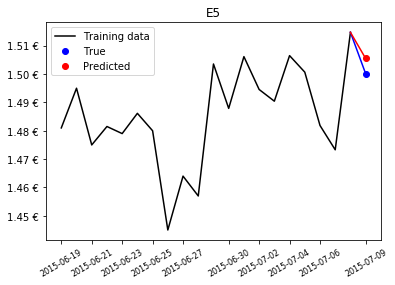

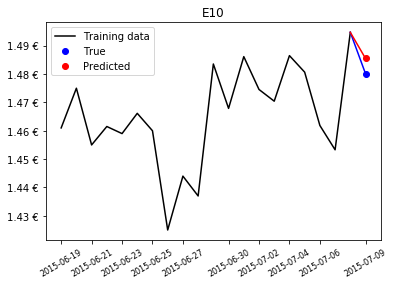

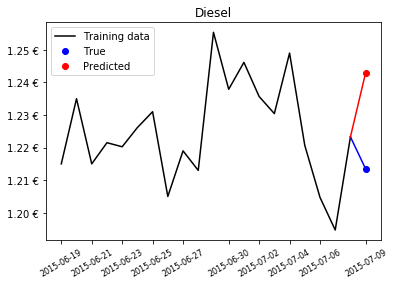

In [272]:
 plot_time_series_pred(e5_train, e5_test, e5_pred, "E5")
plot_time_series_pred(e10_train, e10_test, e10_pred, "E10")
plot_time_series_pred(diesel_train, diesel_test, diesel_pred, "Diesel")

In [273]:
average_mad_e5 = sum(mad_prices_e5_100)/len(mad_prices_e5_100)
average_mad_e10 = sum(mad_prices_e10_100)/len(mad_prices_e10_100)
average_mad_diesel = sum(mad_prices_diesel_100)/len(mad_prices_diesel_100)

mape_prices_e5_100 = [incom for incom in mape_prices_e5_100 if str(incom) != 'nan']
mape_prices_e5_100 = [incom for incom in mape_prices_e5_100 if str(incom) != 'inf']
mape_prices_e10_100 = [incom for incom in mape_prices_e10_100 if str(incom) != 'nan']
mape_prices_e10_100 = [incom for incom in mape_prices_e10_100 if str(incom) != 'inf']

average_mape_e5 = sum(mape_prices_e5_100)/len(mape_prices_e5_100)
average_mape_e10 = sum(mape_prices_e10_100)/len(mape_prices_e10_100)
average_mape_diesel = sum(mape_prices_diesel_100)/len(mape_prices_diesel_100)

print("E5 average mad error: %1.4f €"  % average_mad_e5)
print("E10 average mad error: %1.4f €" % average_mad_e10)
print("Diesel average mad error: %1.4f €" % average_mad_diesel)
print("E5 average mape error: %3.2f %%"  % average_mape_e5)
print("E10 average mape error: %3.2f %%" % average_mape_e10)
print("Diesel average mape error: %3.2f %%" % average_mape_diesel)

E5 average mad error: 0.0218 €
E10 average mad error: 0.0206 €
Diesel average mad error: 0.0186 €
E5 average mape error: 1.51 %
E10 average mape error: 1.46 %
Diesel average mape error: 1.52 %


In [274]:
# lists for mean absolute deviation
mad_prices_e5_prophet = []
mad_prices_e10_prophet = []
mad_list_diesel_prophet = []
# lists of mean absolute percentage error
mape_prices_e5_prophet = []
mape_prices_e10_prophet = []
mape_prices_diesel_prophet = []


e5_100 = pd.DataFrame(stations_100_price_e5).reset_index()
e10_100 = pd.DataFrame(stations_100_price_e5).reset_index()
diesel_100 = pd.DataFrame(stations_100_price_e5).reset_index()

In [275]:
def get_mape_mod(gt, pred):
    if gt == 0:
        gt = 1.2
    mape = 100*np.sum(np.abs((gt - pred)/gt))/pred.shape[0]
    return mape

In [276]:
for train_index, test_index in tscv.split(e5_100.loc[0]):      
    for index, station_e5 in e5_100.iterrows():
        df_station_e5 = pd.DataFrame(np.array([station_e5.index.values, station_e5.values]).T, columns=['ds', 'y'])
        e5_train = df_station_e5.iloc[train_index]
        e5_test = df_station_e5.iloc[test_index].head(test_size) 
        e5_pred = apply_fb_prophet(e5_train, test_size)
        
        mad_prices_e5_prophet.append(get_mad(e5_test["y"].values, e5_pred.tail(test_size)["yhat"].values))
        mape_prices_e5_prophet.append(get_mape_mod(e5_test["y"].values, e5_pred.tail(test_size)["yhat"].values))
   
    for index, station_e10 in e10_100.iterrows():
        df_station_e10 = pd.DataFrame(np.array([station_e10.index.values, station_e10.values]).T, columns=['ds', 'y'])
        e10_train = df_station_e10.iloc[train_index]
        e10_test = df_station_e10.iloc[test_index].head(test_size)
        e10_pred = apply_fb_prophet(e10_train, test_size)
  
        mad_prices_e10_prophet.append(get_mad(e10_test["y"].values, e10_pred.tail(test_size)["yhat"].values))
        mape_prices_e10_prophet.append(get_mape_mod(e10_test["y"].values, e10_pred.tail(test_size)["yhat"].values))
          
    for index, station_diesel in diesel_100.iterrows():
        df_station_diesel = pd.DataFrame(np.array([station_diesel.index.values, station_diesel.values]).T, columns=['ds', 'y'])
        diesel_train = df_station_diesel.iloc[train_index]
        diesel_test = df_station_diesel.iloc[test_index].head(test_size)
        diesel_pred = apply_fb_prophet(diesel_train, test_size)
        
        mad_list_diesel_prophet.append(get_mad(diesel_test["y"].values, diesel_pred.tail(test_size)["yhat"].values))
        mape_prices_diesel_prophet.append(get_mape_mod(diesel_test["y"].values, diesel_pred.tail(test_size)["yhat"].values))


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 15.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 15.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 15.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run pr

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 15.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 15.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 15.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of

INFO:fbprophet:n_changepoints greater than number of observations.Using 15.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 15.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 15.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 15.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonali

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 15.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 15.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 15.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run pr

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 15.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 15.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 15.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of

INFO:fbprophet:n_changepoints greater than number of observations.Using 15.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 15.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 15.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 15.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonali

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 15.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 15.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 15.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run pr

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 15.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 15.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 15.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of

INFO:fbprophet:n_changepoints greater than number of observations.Using 15.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 15.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 15.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 15.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonali

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 15.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 15.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 15.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run pr

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 15.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 15.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 15.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of

INFO:fbprophet:n_changepoints greater than number of observations.Using 15.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 15.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 15.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 15.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonali

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 15.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 15.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 15.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run pr

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 15.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 15.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 15.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of

INFO:fbprophet:n_changepoints greater than number of observations.Using 15.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 15.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 15.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 15.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonali

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 15.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 15.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 15.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run pr

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 15.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 15.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 15.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of

INFO:fbprophet:n_changepoints greater than number of observations.Using 15.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 15.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 15.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 15.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonali

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 15.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 15.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 15.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run pr

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 15.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 15.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 15.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of

INFO:fbprophet:n_changepoints greater than number of observations.Using 15.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 15.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 15.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 15.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonali

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 15.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 15.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 15.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run pr

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 15.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 15.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 15.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of

INFO:fbprophet:n_changepoints greater than number of observations.Using 15.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 15.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 15.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 15.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonali

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 15.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 15.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 15.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run pr

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 15.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 15.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 15.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of

INFO:fbprophet:n_changepoints greater than number of observations.Using 15.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 15.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 15.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 15.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonali

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 15.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 15.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 15.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run pr

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 15.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 15.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 15.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of

INFO:fbprophet:n_changepoints greater than number of observations.Using 15.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 15.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 15.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 15.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonali

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 15.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 15.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 15.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run pr

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 15.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 15.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 15.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of

INFO:fbprophet:n_changepoints greater than number of observations.Using 15.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 15.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 15.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 15.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonali

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 15.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 15.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 15.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run pr

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 15.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 15.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 15.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of

INFO:fbprophet:n_changepoints greater than number of observations.Using 15.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 15.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 15.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 15.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonali

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 15.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 15.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 15.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run pr

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 15.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 15.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 15.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of

INFO:fbprophet:n_changepoints greater than number of observations.Using 15.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 15.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 15.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 15.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonali

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 15.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 15.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 15.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run pr

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 15.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 15.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 15.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of

INFO:fbprophet:n_changepoints greater than number of observations.Using 15.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 15.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 15.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 15.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonali

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 15.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 15.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 15.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run pr

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 15.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 15.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 15.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of

INFO:fbprophet:n_changepoints greater than number of observations.Using 15.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 15.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 15.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 15.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonali

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 15.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 15.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 15.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run pr

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 15.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 15.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 15.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of

INFO:fbprophet:n_changepoints greater than number of observations.Using 15.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 15.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 15.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 15.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonali

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 15.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 15.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 15.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run pr

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 15.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 15.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 15.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of

INFO:fbprophet:n_changepoints greater than number of observations.Using 15.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 15.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 15.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 15.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonali

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 15.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 15.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 15.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run pr

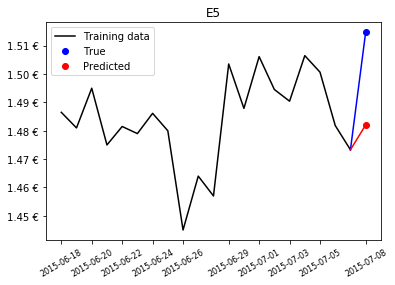

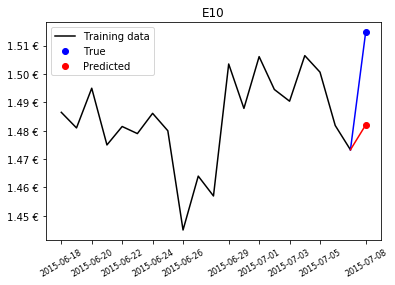

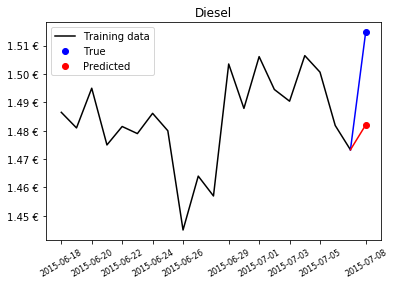

In [277]:
plot_time_series_pred_prophet(e5_train, e5_test, e5_pred, "E5")
plot_time_series_pred_prophet(e10_train, e10_test, e10_pred, "E10")
plot_time_series_pred_prophet(diesel_train, diesel_test, diesel_pred, "Diesel")

In [278]:
average_mad_e5 = sum(mad_prices_e5_prophet)/len(mad_prices_e5_prophet)
average_mad_e10 = sum(mad_prices_e10_prophet)/len(mad_prices_e10_prophet)
average_mad_diesel = sum(mad_prices_diesel_prophet)/len(mad_prices_diesel_prophet)
average_mape_e5 = sum(mape_prices_e5_prophet)/len(mape_prices_e5_prophet)
average_mape_e10 = sum(mape_prices_e10_prophet)/len(mape_prices_e10_prophet)
average_mape_diesel = sum(mape_prices_diesel_prophet)/len(mape_prices_diesel_prophet)

print("E5 average mad error: %1.4f €"  % average_mad_e5)
print("E10 average mad error: %1.4f €" % average_mad_e10)
print("Diesel average mad error: %1.4f €" % average_mad_diesel)
print("E5 average mape error: %3.2f %%"  % average_mape_e5)
print("E10 average mape error: %3.2f %%" % average_mape_e10)
print("Diesel average mape error: %3.2f %%" % average_mape_diesel)

E5 average mad error: 0.0259 €
E10 average mad error: 0.0259 €
Diesel average mad error: 0.0146 €
E5 average mape error: 2.23 %
E10 average mape error: 2.23 %
Diesel average mape error: 2.23 %
